In [1]:
import sys
sys.path.append('../centroFlye_repo/scripts')

from collections import defaultdict, Counter

import numpy as np
import heapq
import pysam

import matplotlib
%matplotlib inline 
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

from utils.bio import read_bio_seq
from ncrf_parser import NCRF_Report
from distance_based_kmer_recruitment import get_kmer_freqs_from_ncrf_report

%load_ext autoreload
%autoreload 2

In [2]:
plt.rcParams['figure.figsize'] = [10, 8]


In [3]:
reads_ncrf_fn = "../data/reads_ncrf_report.txt"
dxz1_fn = "../data/DXZ1_rc.fasta"
updated_dxz1_fn = "../data/DXZ1_rc_star.fasta"

In [4]:
reads_ncrf_report = NCRF_Report(reads_ncrf_fn)
dxz1_seq = read_bio_seq(dxz1_fn)
updated_dxz1_seq = read_bio_seq(updated_dxz1_fn)

# Estimate of survival rate

To rerun this analysis, please uncomment the code in the following cell

In [5]:
# rel2_to_GRCh38_url = "https://s3.amazonaws.com/nanopore-human-wgs/chm13/nanopore/rel2/rel2_to_GRCh38.cram"
# !wget {rel2_to_GRCh38_url} -P ../data
# !samtools index ../data/rel2_to_GRCh38.cram

In [6]:
read_true_alignments = \
"../data/rel2_to_GRCh38.cram"
bamfile = pysam.AlignmentFile(read_true_alignments, "rb")

In [7]:
k = 19
chromosome = 'chr22'
positions = [44429523 + x for x in range(0, 5000, 5)]

In [8]:
perc_ident = defaultdict(int)
perc_corrupted = defaultdict(int)
for i, pos in enumerate(positions):
    kmer = None
    for read in bamfile.fetch(contig=chromosome, start=pos, stop=pos+k):
        if read.reference_start > pos or read.reference_end < pos + k:
            continue
        tuples = read.get_aligned_pairs(with_seq=True)
        selected_tuples = [x for x in tuples \
                           if x[1] is not None and (pos <= x[1] <= pos+k)]
        start_on_read, end_on_read = selected_tuples[0][0], selected_tuples[-1][0]
        start_on_ref = selected_tuples[0][1] - read.reference_start
        end_on_ref = start_on_ref + k
        
        read_substr = read.query_sequence[start_on_read:end_on_read]
        ref_substr = read.get_reference_sequence()[start_on_ref:end_on_ref].upper()
        
        if kmer is None:
            kmer = ref_substr
        else:
            if kmer != ref_substr:
                print(kmer, ref_substr)
                print(pos, read.reference_end, pos +k)
            assert kmer == ref_substr
        if ref_substr == read_substr:
            perc_ident[ref_substr] += 1
        else:
            perc_corrupted[ref_substr] += 1
    print(i, pos, kmer, perc_ident[kmer], perc_corrupted[kmer])

0 44429523 CATTCGAGTTTGCCTGATA 9 22
1 44429528 GAGTTTGCCTGATAGAGAA 10 21
2 44429533 TGCCTGATAGAGAAGCTGA 10 21
3 44429538 GATAGAGAAGCTGACAACA 12 19
4 44429543 AGAAGCTGACAACATTGTC 14 17
5 44429548 CTGACAACATTGTCTGCAT 10 21
6 44429553 AACATTGTCTGCATAAAAG 11 20
7 44429558 TGTCTGCATAAAAGTGGAA 9 22
8 44429563 GCATAAAAGTGGAAAGCTC 8 23
9 44429568 AAAGTGGAAAGCTCCTATA 6 25
10 44429573 GGAAAGCTCCTATATGGCA 4 26
11 44429578 GCTCCTATATGGCAAAGGA 5 25
12 44429583 TATATGGCAAAGGAATGAA 7 23
13 44429588 GGCAAAGGAATGAAAACAA 9 21
14 44429593 AGGAATGAAAACAAAGCAA 6 24
15 44429598 TGAAAACAAAGCAAAAAGA 5 25
16 44429603 ACAAAGCAAAAAGACATAT 8 22
17 44429608 GCAAAAAGACATATGTCAG 8 22
18 44429613 AAGACATATGTCAGAGGAA 13 17
19 44429618 ATATGTCAGAGGAAGAGAA 12 18
20 44429623 TCAGAGGAAGAGAAAGCAT 9 21
21 44429628 GGAAGAGAAAGCATTTTCC 8 22
22 44429633 AGAAAGCATTTTCCACACG 7 23
23 44429638 GCATTTTCCACACGCATAA 10 20
24 44429643 TTCCACACGCATAACAAAG 12 18
25 44429648 CACGCATAACAAAGGCTTA 11 19
26 44429653 ATAACAAAGGCTTAATAGC 7 23


216 44430603 AGGGCTTGAACCATGCCTC 13 18
217 44430608 TTGAACCATGCCTCTCACA 14 17
218 44430613 CCATGCCTCTCACAGAAGG 10 21
219 44430618 CCTCTCACAGAAGGGCTGA 9 22
220 44430623 CACAGAAGGGCTGATCTAA 8 23
221 44430628 AAGGGCTGATCTAAGAGGC 8 23
222 44430633 CTGATCTAAGAGGCCCATG 12 19
223 44430638 CTAAGAGGCCCATGCTAGT 9 22
224 44430643 AGGCCCATGCTAGTGTTCA 16 15
225 44430648 CATGCTAGTGTTCAACTCT 14 17
226 44430653 TAGTGTTCAACTCTGACAT 17 14
227 44430658 TTCAACTCTGACATTCATA 16 15
228 44430663 CTCTGACATTCATAAGGGG 2 29
229 44430668 ACATTCATAAGGGGGGGAA 0 31
230 44430673 CATAAGGGGGGGAAAGCCA 0 31
231 44430678 GGGGGGGAAAGCCAGATGT 0 31
232 44430683 GGAAAGCCAGATGTGCTCC 7 24
233 44430688 GCCAGATGTGCTCCTACCA 9 22
234 44430693 ATGTGCTCCTACCAGCCCA 9 22
235 44430698 CTCCTACCAGCCCACCAGG 11 20
236 44430703 ACCAGCCCACCAGGAGGGC 11 20
237 44430708 CCCACCAGGAGGGCTAAAA 6 25
238 44430713 CAGGAGGGCTAAAATCAAA 4 27
239 44430718 GGGCTAAAATCAAAAGGGC 5 26
240 44430723 AAAATCAAAAGGGCCCTCC 6 25
241 44430728 CAAAAGGGCCCTCCTCTCC 2 29
24

499 44432018 TGTGCAGTAAAAGGGGAAA 10 20
500 44432023 AGTAAAAGGGGAAAGAGAG 9 21
501 44432028 AAGGGGAAAGAGAGGGTTC 12 18
502 44432033 GAAAGAGAGGGTTCTGGGC 12 18
503 44432038 AGAGGGTTCTGGGCCCCAG 12 18
504 44432043 GTTCTGGGCCCCAGGGGTT 10 20
505 44432048 GGGCCCCAGGGGTTGCGTG 9 21
506 44432053 CCAGGGGTTGCGTGGGCTG 8 22
507 44432058 GGTTGCGTGGGCTGAGTTT 10 20
508 44432063 CGTGGGCTGAGTTTGGGAA 9 21
509 44432068 GCTGAGTTTGGGAAACAGG 8 22
510 44432073 GTTTGGGAAACAGGGTGTG 9 21
511 44432078 GGAAACAGGGTGTGACCAG 8 22
512 44432083 CAGGGTGTGACCAGCAGAA 11 19
513 44432088 TGTGACCAGCAGAAGAAAT 11 19
514 44432093 CCAGCAGAAGAAATACAAA 16 14
515 44432098 AGAAGAAATACAAAAATCC 17 13
516 44432103 AAATACAAAAATCCATCCT 17 13
517 44432108 CAAAAATCCATCCTCTTTC 5 25
518 44432113 ATCCATCCTCTTTCCTCAT 5 25
519 44432118 TCCTCTTTCCTCATCAGGG 4 26
520 44432123 TTTCCTCATCAGGGAAATG 4 26
521 44432128 TCATCAGGGAAATGAAAAT 9 21
522 44432133 AGGGAAATGAAAATGACAA 9 21
523 44432138 AATGAAAATGACAACCAGA 12 18
524 44432143 AAATGACAACCAGAGGCCA 17 13

712 44433083 CAGGCTACATCTTATTCTC 10 18
713 44433088 TACATCTTATTCTCTAAAA 10 18
714 44433093 CTTATTCTCTAAAACAGAG 9 19
715 44433098 TCTCTAAAACAGAGTGGGT 9 19
716 44433103 AAAACAGAGTGGGTGTTGC 8 20
717 44433108 AGAGTGGGTGTTGCACGGA 7 21
718 44433113 GGGTGTTGCACGGAGCTGA 9 19
719 44433118 TTGCACGGAGCTGAGCAGA 14 14
720 44433123 CGGAGCTGAGCAGATGGGG 14 14
721 44433128 CTGAGCAGATGGGGTGGGC 15 13
722 44433133 CAGATGGGGTGGGCTTTAC 16 12
723 44433138 GGGGTGGGCTTTACAGGCA 15 13
724 44433143 GGGCTTTACAGGCAGAAAA 9 19
725 44433148 TTACAGGCAGAAAAGGGCT 11 17
726 44433153 GGCAGAAAAGGGCTGAAGG 11 17
727 44433158 AAAAGGGCTGAAGGAATGA 15 13
728 44433163 GGCTGAAGGAATGAAAAGC 17 11
729 44433168 AAGGAATGAAAAGCAGACT 17 11
730 44433173 ATGAAAAGCAGACTGGTCA 16 12
731 44433178 AAGCAGACTGGTCATTTCA 15 13
732 44433183 GACTGGTCATTTCAAAGTT 13 15
733 44433188 GTCATTTCAAAGTTACTTT 13 15
734 44433193 TTCAAAGTTACTTTATAGG 10 18
735 44433198 AGTTACTTTATAGGGCTGA 10 18
736 44433203 CTTTATAGGGCTGAAACAG 9 19
737 44433208 TAGGGCTGAAACAGAAGGA

924 44434143 ACTACACTTGGCCCATGGC 8 21
925 44434148 ACTTGGCCCATGGCCCCTT 9 20
926 44434153 GCCCATGGCCCCTTCCTCC 9 20
927 44434158 TGGCCCCTTCCTCCATCTC 9 20
928 44434163 CCTTCCTCCATCTCCAAAG 12 17
929 44434168 CTCCATCTCCAAAGCTCAT 13 16
930 44434173 TCTCCAAAGCTCATCACTC 14 15
931 44434178 AAAGCTCATCACTCTGGTC 10 19
932 44434183 TCATCACTCTGGTCTCTGC 12 17
933 44434188 ACTCTGGTCTCTGCTTCTG 10 19
934 44434193 GGTCTCTGCTTCTGTGAAT 11 18
935 44434198 CTGCTTCTGTGAATGTGGC 12 17
936 44434203 TCTGTGAATGTGGCCTTCT 11 18
937 44434208 GAATGTGGCCTTCTCCTTC 11 18
938 44434213 TGGCCTTCTCCTTCTCCTG 8 21
939 44434218 TTCTCCTTCTCCTGCCTCC 10 19
940 44434223 CTTCTCCTGCCTCCTGCCT 9 20
941 44434228 CCTGCCTCCTGCCTCTTCC 9 20
942 44434233 CTCCTGCCTCTTCCATTCC 10 19
943 44434238 GCCTCTTCCATTCCTCTTC 12 17
944 44434243 TTCCATTCCTCTTCTAAGG 14 15
945 44434248 TTCCTCTTCTAAGGATGGT 12 17
946 44434253 CTTCTAAGGATGGTTGGAA 9 20
947 44434258 AAGGATGGTTGGAATGACA 11 18
948 44434263 TGGTTGGAATGACAGGCCC 8 21
949 44434268 GGAATGACAGGCCCAGCTA 7

In [9]:
survival_rate = []
for kmer in perc_ident:
    ident = perc_ident[kmer]
    corrupted = perc_corrupted[kmer]
    survival_rate.append(ident / (ident + corrupted))

In [10]:
mean_survival_rate = np.mean(survival_rate)
print(mean_survival_rate)

0.341223551631


# Rare kmers (Figure 2, Left)

In [11]:
reads_ncrf_fn = "../data/reads_ncrf_report.txt"

In [12]:
reads_ncrf_report = NCRF_Report(reads_ncrf_fn)


In [13]:
all_kmers = get_kmer_freqs_from_ncrf_report(reads_ncrf_report, k=19,verbose=False,max_nonuniq=3)

In [14]:
for k, v in all_kmers.items():
    assert '-' not in k

Total number of kmers

In [15]:
len(all_kmers)

15800867

In [16]:
coverage = 32
bottom, top = 0.9, 3
filtered_kmers = {kmer: v for kmer, v in all_kmers.items() \
                  if bottom*coverage*mean_survival_rate <= v <= top*coverage*mean_survival_rate}

Number of filtered kmers

In [17]:
len(filtered_kmers)

391361

Histogram of kmers (rare are in blue)

In [18]:
counter_all_kmers = Counter(all_kmers.values())
counter_filtered_kmers = Counter(filtered_kmers.values())

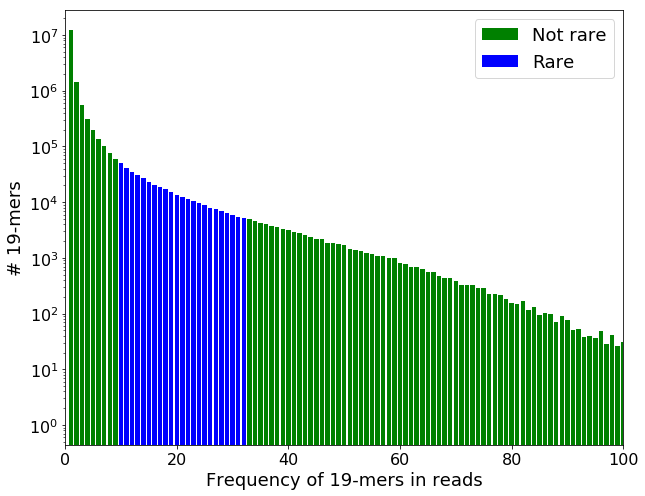

In [19]:
plt.bar(counter_all_kmers.keys(), counter_all_kmers.values(), color='green')
plt.bar(counter_filtered_kmers.keys(), counter_filtered_kmers.values(), color='blue')
plt.yscale('log')
plt.xlim(0, 100)
#plt.title(f'Frequency histogram of {k}-mers in centromeric reads', fontsize=20)
plt.xlabel('Frequency of 19-mers in reads', fontsize=18)
plt.ylabel('# 19-mers', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(['Not rare', 'Rare'], fontsize=18)